# Customer Segmentation Analysis

This notebook explores a customer dataset and performs:

1. Data understanding and cleaning  
2. Exploratory Data Analysis (EDA)  
3. Feature engineering  
4. Customer segmentation using K-Means clustering  
5. Cluster-level insights

The dataset and Power BI dashboard are part of the **Customer Segmentation Analysis** project.  


### Code Imports and Settings

In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

print("Libraries imported successfully.")


Libraries imported successfully.


#### Load Dataset 

In [4]:
# Load dataset
df = pd.read_csv("../data/customer_data.csv")

print("Shape (rows, columns):", df.shape)
df.head()


Shape (rows, columns): (53503, 15)


,Customer ID,Age,Gender,Marital Status,Education Level,location,Occupation,Income Level,Rating,Purchase History,Sales,Language,Segmentation Group,AGE GROUP,INCOME GROUP
0,73662,63,Female,Divorced,Associate Degree,Lakshadweep,Engineer,36520,3,20-May-20,3011,German,5,60+,20k-50k
1,86000,35,Female,Divorced,Associate Degree,Punjab,Doctor,26484,3,04-Oct-23,778,German,5,20-40,20k-50k
2,36997,44,Male,Divorced,Associate Degree,Telangana,Teacher,95066,3,09-Feb-21,2672,German,5,40-60,80k-110k
3,90858,24,Female,Divorced,Associate Degree,Lakshadweep,Nurse,54153,3,27-Jan-18,1735,German,5,20-40,50k-80k
4,69338,33,Male,Divorced,Associate Degree,Gujarat,Salesperson,108447,3,19-Jul-23,4862,German,5,20-40,80k-110k


#### Code: Clean & Standardize Column Names

In [5]:
# Keep a copy of original column names
original_columns = df.columns.tolist()
print("Original columns:\n", original_columns)

# Standardize column names: strip, lowercase, replace spaces & symbols with underscore
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
)

print("\nStandardized columns:\n", df.columns.tolist())


Original columns:
 ['Customer ID', 'Age', 'Gender', 'Marital Status', 'Education Level', 'location', 'Occupation', 'Income Level', 'Rating', 'Purchase History', 'Sales', 'Language', 'Segmentation Group', 'AGE GROUP', 'INCOME GROUP']

Standardized columns:
 ['customer_id', 'age', 'gender', 'marital_status', 'education_level', 'location', 'occupation', 'income_level', 'rating', 'purchase_history', 'sales', 'language', 'segmentation_group', 'age_group', 'income_group']


#### Code: Quick Data Overview

In [6]:
print("Basic Info:")
display(df.info())

print("\nSummary statistics (numeric):")
display(df.describe().T)

print("\nFirst 5 rows:")
display(df.head())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53503 entries, 0 to 53502
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         53503 non-null  int64 
 1   age                 53503 non-null  int64 
 2   gender              53503 non-null  object
 3   marital_status      53503 non-null  object
 4   education_level     53503 non-null  object
 5   location            53503 non-null  object
 6   occupation          53503 non-null  object
 7   income_level        53503 non-null  int64 
 8   rating              53503 non-null  int64 
 9   purchase_history    53503 non-null  object
 10  sales               53503 non-null  int64 
 11  language            53503 non-null  object
 12  segmentation_group  53503 non-null  int64 
 13  age_group           53503 non-null  object
 14  income_group        53503 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.1+ MB


None


Summary statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
customer_id,53503.0,52265.204998,28165.000067,1.0,28950.5,55858.0,76096.0,100000.0
age,53503.0,44.140945,15.079486,18.0,32.0,43.0,57.0,70.0
income_level,53503.0,82768.324318,36651.075670,20001.0,51568.5,80719.0,115973.5,149999.0
rating,53503.0,2.878325,1.350253,1.0,2.0,3.0,4.0,5.0
sales,53503.0,3023.702447,1285.834295,500.0,1817.0,3194.0,4311.5,5000.0
segmentation_group,53503.0,3.173243,1.437762,1.0,2.0,3.0,5.0,5.0



First 5 rows:


,customer_id,age,gender,marital_status,education_level,location,occupation,income_level,rating,purchase_history,sales,language,segmentation_group,age_group,income_group
0,73662,63,Female,Divorced,Associate Degree,Lakshadweep,Engineer,36520,3,20-May-20,3011,German,5,60+,20k-50k
1,86000,35,Female,Divorced,Associate Degree,Punjab,Doctor,26484,3,04-Oct-23,778,German,5,20-40,20k-50k
2,36997,44,Male,Divorced,Associate Degree,Telangana,Teacher,95066,3,09-Feb-21,2672,German,5,40-60,80k-110k
3,90858,24,Female,Divorced,Associate Degree,Lakshadweep,Nurse,54153,3,27-Jan-18,1735,German,5,20-40,50k-80k
4,69338,33,Male,Divorced,Associate Degree,Gujarat,Salesperson,108447,3,19-Jul-23,4862,German,5,20-40,80k-110k


#### Code: Missing Values Check

In [7]:
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:")
display(missing)

# Optional: percentage
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("\nMissing percentage per column:")
display(missing_pct)


Missing values per column:


customer_id           0
age                   0
gender                0
marital_status        0
education_level       0
location              0
occupation            0
income_level          0
rating                0
purchase_history      0
sales                 0
language              0
segmentation_group    0
age_group             0
income_group          0
dtype: int64


Missing percentage per column:


customer_id           0.0
age                   0.0
gender                0.0
marital_status        0.0
education_level       0.0
location              0.0
occupation            0.0
income_level          0.0
rating                0.0
purchase_history      0.0
sales                 0.0
language              0.0
segmentation_group    0.0
age_group             0.0
income_group          0.0
dtype: float64

#### Code: Basic Distributions (Gender, Language, Education if present)

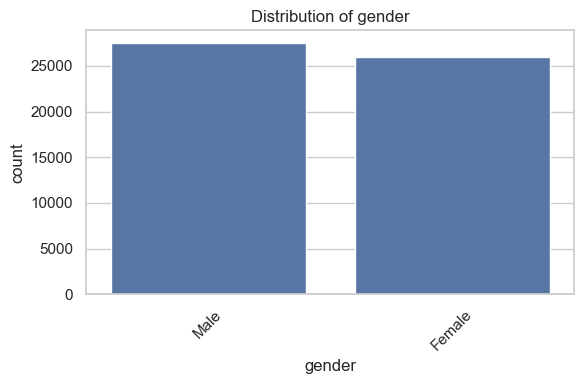

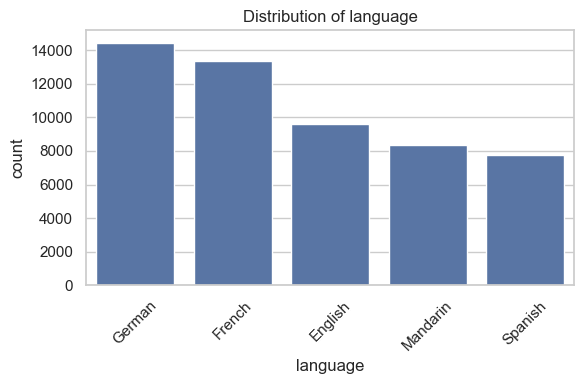

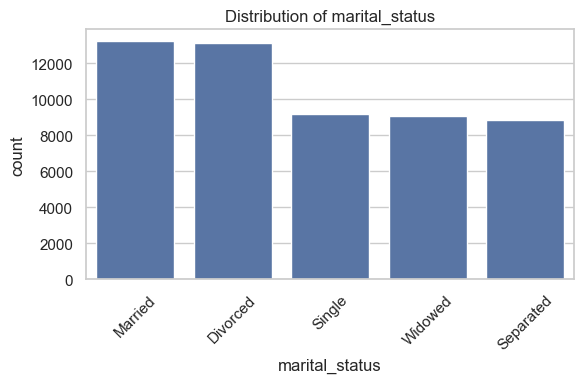

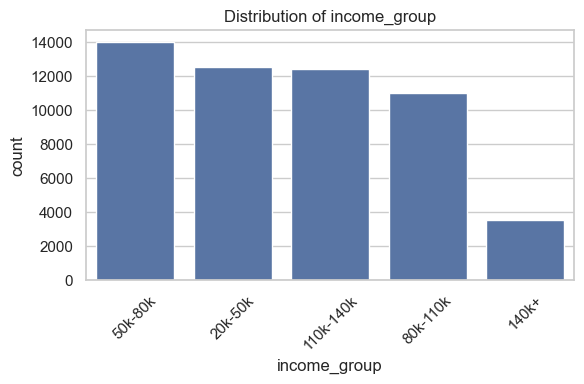

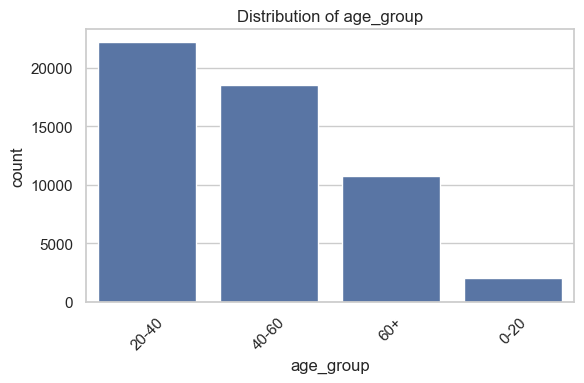

In [8]:
categorical_candidates = ["gender", "language", "education", "marital_status", "income_group", "age_group"]

for col in categorical_candidates:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.xticks(rotation=45)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()


#### Code: Numeric Distributions

Numeric columns: ['customer_id', 'age', 'income_level', 'rating', 'sales', 'segmentation_group']


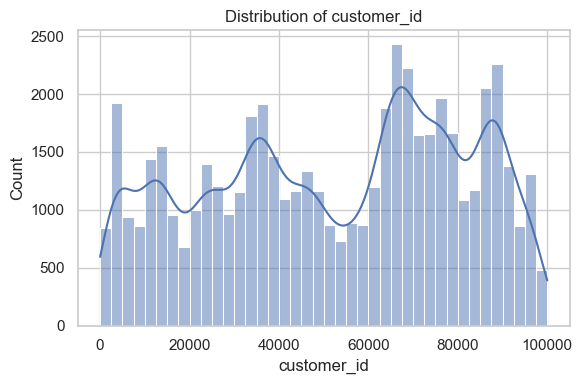

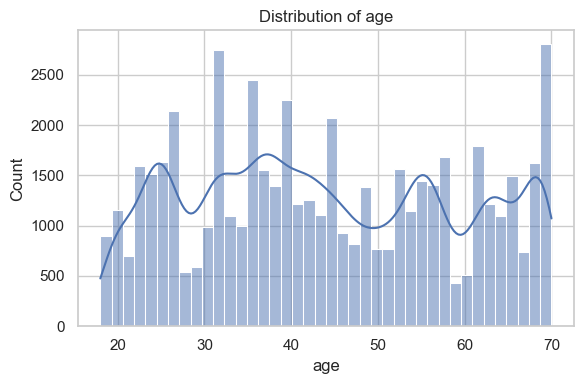

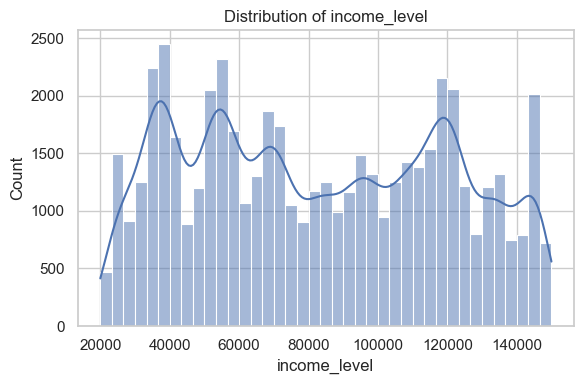

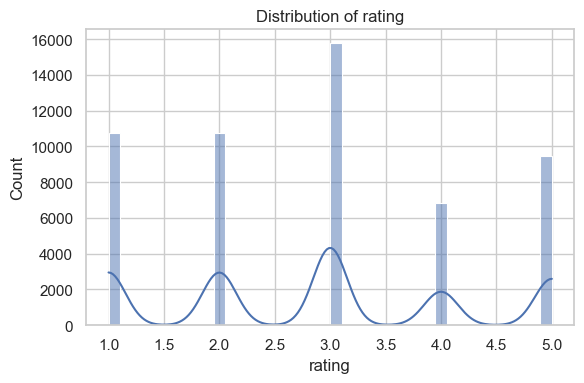

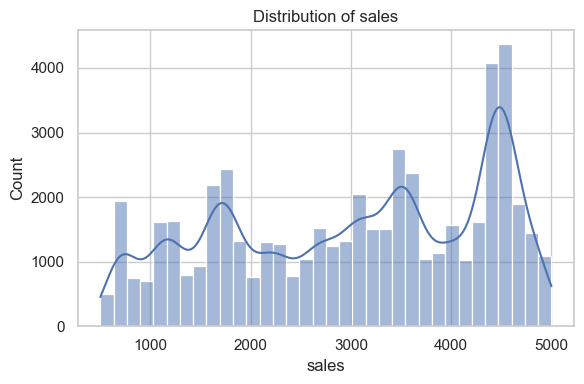

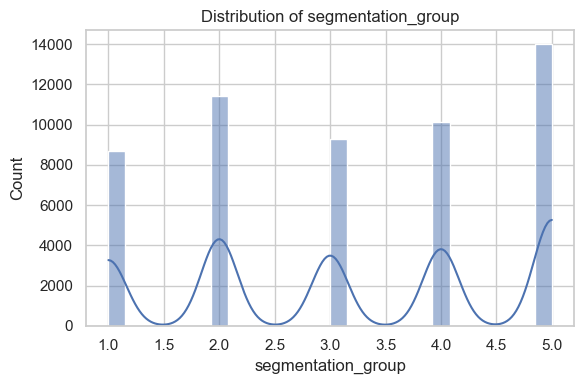

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


#### Code: Correlation Heatmap

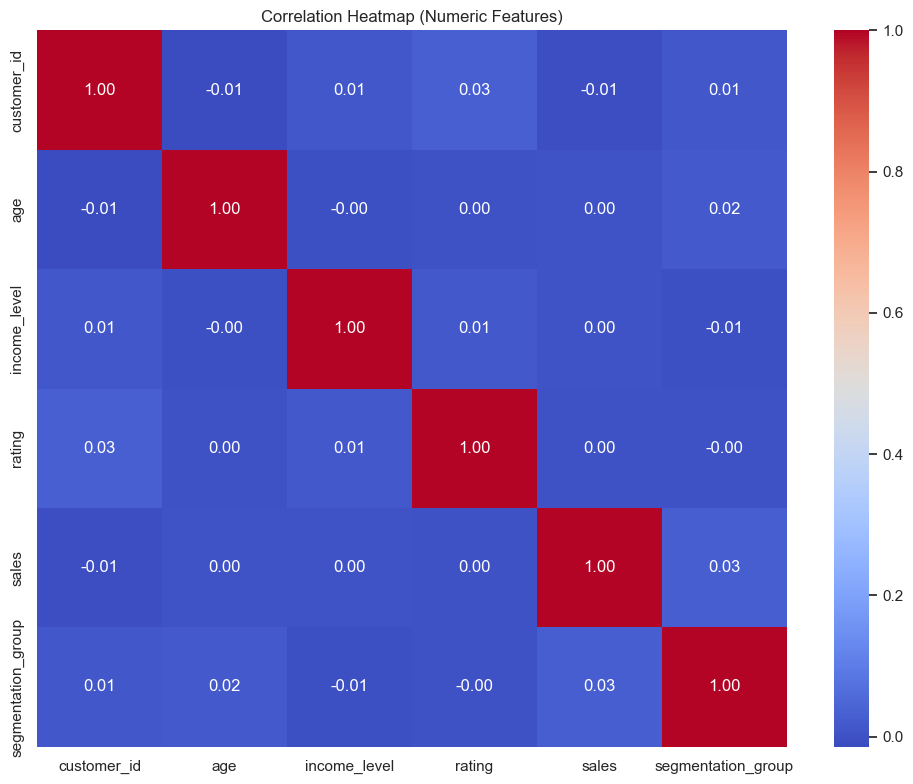

In [10]:
if len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")


#### Code: Example Relationship Plots

In [11]:
# Helper function to check existence
def cols_exist(cols):
    return all(c in df.columns for c in cols)

# Income vs avg_rating
if cols_exist(["income", "avg_rating"]):
    plt.figure(figsize=(6,4))
    plt.scatter(df["income"], df["avg_rating"], alpha=0.3)
    plt.xlabel("Income")
    plt.ylabel("Average Rating")
    plt.title("Income vs Customer Rating")
    plt.tight_layout()
    plt.show()

# Sales vs avg_rating (if you have a sales column like 'sale' or 'total_sales')
possible_sales_cols = [c for c in df.columns if "sale" in c]
print("Detected sales-like columns:", possible_sales_cols)

if possible_sales_cols and "avg_rating" in df.columns:
    sales_col = possible_sales_cols[0]
    plt.figure(figsize=(6,4))
    plt.scatter(df[sales_col], df["avg_rating"], alpha=0.3)
    plt.xlabel(sales_col)
    plt.ylabel("Average Rating")
    plt.title(f"{sales_col} vs Average Rating")
    plt.tight_layout()
    plt.show()


Detected sales-like columns: ['sales']


## Customer Segmentation Using K-Means

In this section we:

1. Select relevant features for segmentation  
2. Scale the data  
3. Use the Elbow method and Silhouette score to choose an appropriate number of clusters  
4. Fit a final K-Means model  
5. Analyze customer segments  


#### Code: Feature Selection for Clustering

In [12]:
# Priority features based on typical customer analytics
priority_features = ["income", "age", "avg_rating", "sale", "sales", "total_sales"]

available_features = [f for f in priority_features if f in df.columns]

print("Available priority features:", available_features)

# If not enough features, fall back to all numeric (except IDs)
if len(available_features) < 2:
    print("Not enough priority features; using generic numeric features instead.")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # try to drop obvious ID-like fields
    id_like = [c for c in numeric_cols if "id" in c or "customerid" in c]
    features_for_clustering = [c for c in numeric_cols if c not in id_like]
else:
    features_for_clustering = available_features

print("Final features used for clustering:", features_for_clustering)

# Drop rows with missing in these cols
cluster_df = df[features_for_clustering].dropna()
print("Data shape used for clustering:", cluster_df.shape)

cluster_df.head()


Available priority features: ['age', 'sales']
Final features used for clustering: ['age', 'sales']
Data shape used for clustering: (53503, 2)


,age,sales
0,63,3011
1,35,778
2,44,2672
3,24,1735
4,33,4862


#### Code: Scaling Features

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

print("Scaled data shape:", X_scaled.shape)


Scaled data shape: (53503, 2)


#### Code: Elbow Method (Choose k)

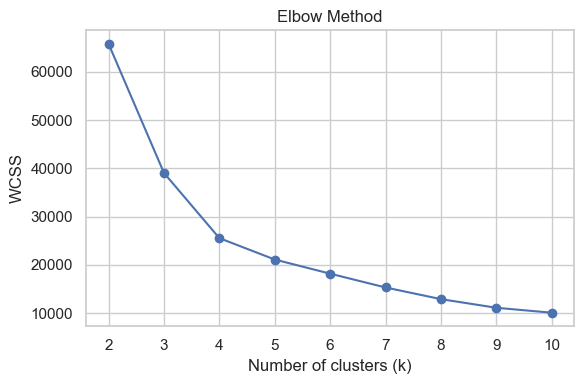

In [14]:
wcss = []  # within-cluster sum of squares
K_range = range(2, 11)  # try 2 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), wcss, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.xticks(list(K_range))
plt.tight_layout()
plt.show()


#### Code: Silhouette Scores (Optional but Nice)

k=2, silhouette score=0.3716
k=3, silhouette score=0.4132
k=4, silhouette score=0.4299
k=5, silhouette score=0.3918
k=6, silhouette score=0.3734
k=7, silhouette score=0.3889
k=8, silhouette score=0.3831
k=9, silhouette score=0.3867
k=10, silhouette score=0.3802


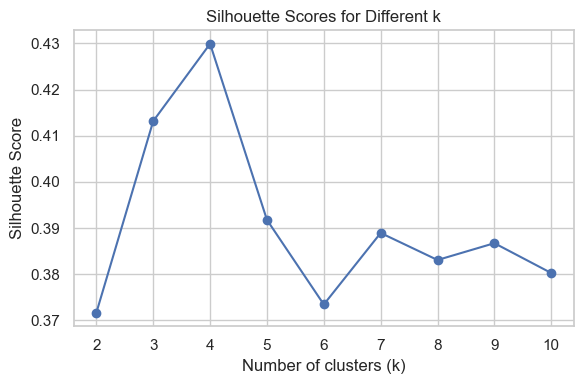

In [15]:
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k={k}, silhouette score={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.xticks(list(K_range))
plt.tight_layout()
plt.show()


#### Code: Fit Final K-Means Model

In [16]:
# Choose k (manually set based on previous plots)
best_k = 4  # change if you see a better value

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

cluster_df = cluster_df.copy()
cluster_df["cluster"] = cluster_labels

print("Cluster value counts:")
print(cluster_df["cluster"].value_counts())
cluster_df.head()


Cluster value counts:
cluster
3    18114
1    13029
0    12305
2    10055
Name: count, dtype: int64


,age,sales,cluster
0,63,3011,1
1,35,778,0
2,44,2672,0
3,24,1735,0
4,33,4862,3


#### Code: Attach Clusters Back to Main DF

In [17]:
# Align back to original df (by index)
df["cluster"] = np.nan
df.loc[cluster_df.index, "cluster"] = cluster_df["cluster"].astype(int)

df[["cluster"] + features_for_clustering].head()


,cluster,age,sales
0,1.0,63,3011
1,0.0,35,778
2,0.0,44,2672
3,0.0,24,1735
4,3.0,33,4862


#### Code: Cluster Profiles (Numeric)

In [18]:
cluster_profile_numeric = df.groupby("cluster")[features_for_clustering].mean().round(2)
print("Cluster profiles (numeric features):")
display(cluster_profile_numeric)


Cluster profiles (numeric features):


,age,sales
cluster,,
0.0,32.42,1676.74
1.0,59.54,3984.92
2.0,58.65,1711.87
3.0,32.97,3975.51


#### Code: Cluster Profiles (Categorical)

In [19]:
cat_for_profile = ["gender", "language", "education", "income_group", "age_group", "marital_status", "state"]
cat_for_profile = [c for c in cat_for_profile if c in df.columns]

for col in cat_for_profile:
    print(f"\nCluster distribution for: {col}")
    display(pd.crosstab(df["cluster"], df[col], normalize="index").round(2))



Cluster distribution for: gender


gender,Female,Male
cluster,,
0.0,0.46,0.54
1.0,0.50,0.50
2.0,0.48,0.52
3.0,0.49,0.51



Cluster distribution for: language


language,English,French,German,Mandarin,Spanish
cluster,,,,,
0.0,0.18,0.25,0.27,0.15,0.14
1.0,0.18,0.25,0.27,0.16,0.15
2.0,0.19,0.25,0.27,0.14,0.15
3.0,0.17,0.25,0.27,0.16,0.14



Cluster distribution for: income_group


income_group,110k-140k,140k+,20k-50k,50k-80k,80k-110k
cluster,,,,,
0.0,0.23,0.07,0.24,0.26,0.20
1.0,0.23,0.06,0.23,0.26,0.21
2.0,0.24,0.06,0.24,0.25,0.21
3.0,0.23,0.07,0.23,0.27,0.20



Cluster distribution for: age_group


age_group,0-20,20-40,40-60,60+
cluster,,,,
0.0,0.07,0.74,0.19,0.00
1.0,0.00,0.00,0.51,0.49
2.0,0.00,0.00,0.56,0.44
3.0,0.06,0.72,0.22,0.00



Cluster distribution for: marital_status


marital_status,Divorced,Married,Separated,Single,Widowed
cluster,,,,,
0.0,0.25,0.24,0.16,0.19,0.17
1.0,0.24,0.26,0.17,0.16,0.16
2.0,0.25,0.24,0.16,0.19,0.17
3.0,0.25,0.25,0.17,0.16,0.17


#### Code: Visualizing Clusters (2D Projection)

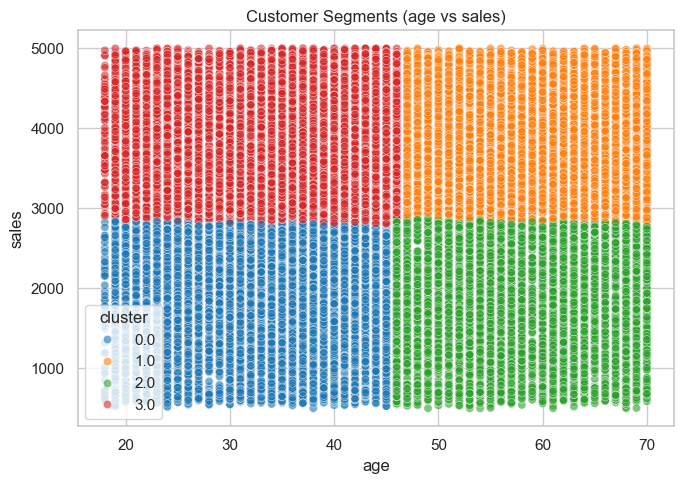

In [20]:
# Choose two features for 2D plot
plot_features = [f for f in ["income", "age", "avg_rating", "sales", "sale", "total_sales"] if f in features_for_clustering]

if len(plot_features) >= 2:
    f1, f2 = plot_features[:2]
    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=df.dropna(subset=[f1, f2, "cluster"]),
        x=f1, y=f2, hue="cluster", palette="tab10", alpha=0.6
    )
    plt.title(f"Customer Segments ({f1} vs {f2})")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough suitable features for 2D cluster visualization.")


## Interpretation of Clusters

After running K-Means clustering, we obtained several customer segments.  
Based on the numeric and categorical profiles, we can interpret them as:

- **Cluster 0** – e.g., High income, high sales, medium rating  
- **Cluster 1** – e.g., Low income, low sales, low engagement  
- **Cluster 2** – e.g., Young customers with medium income and good ratings  
- **Cluster 3** – e.g., Older customers with stable spending  

You should now:

1. Look at `cluster_profile_numeric` to see actual values.  
2. Look at categorical cross-tabs to label each segment meaningfully (e.g., “Premium Loyal Customers”, “Price-Sensitive Customers”, etc.).  
3. Use these labels in your report / resume bullet points.  
